# Transfer Learning to classify keep or throwaway necklace model with VGG

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import cv2
import os
import time

from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from tensorflow.keras import backend as K
from tensorflow.keras import metrics, optimizers
%tensorflow_version 1.x

## Define paths & constants

In [ ]:
data_base_path = "/content/drive/My Drive/labeled/"
save_dir = os.path.abspath("/content/drive/My Drive/Colab Notebooks/")

In [4]:
print(len(os.listdir(data_base_path+"throwaway/")))
print(len(os.listdir(data_base_path+"keep/")))

973
975


In [ ]:
nb_classes = 2
batch_size = 32
nb_train_samples = batch_size*6
nb_validation_samples = batch_size*1
nb_epochs = 100

#IMAGE_RESIZE = 150
img_height = 150
img_width = 150

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

## Build model

In [6]:
# Extract base of VGG16 model:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=input_shape)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
58892288/58889256 [==============================] - 1s 0us/step


In [41]:
# Add 2 trainable layers on top:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(512*4, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512*4, activation='relu'))
model.add(Dense(nb_classes, activation='softmax'))

conv_base.trainable = True
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 32
This is the number of trainable weights after freezing the conv base: 6


## Preprocess data  
  
Randomly generate training & validation data

In [ ]:
train_gen = ImageDataGenerator(
    rescale=1./255, 
    horizontal_flip=True, 
#    vertical_flip=True,
    rotation_range=40, 
    width_shift_range=.15,
    height_shift_range=.15,
#    zoom_range=0.5,
    validation_split=0.2) # set validation split

#test_datagen = ImageDataGenerator(rescale=1./255)

In [43]:
train_generator = train_gen.flow_from_directory(
    data_base_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training') # set as training data
    # shuffles by default

validation_generator = train_gen.flow_from_directory(
    data_base_path, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation') # set as validation data

Found 1558 images belonging to 2 classes.
Found 388 images belonging to 2 classes.


### Inspect a batch

In [ ]:
sample_training_images, _ = next(train_generator)

In [ ]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
plotImages(sample_training_images[:5])

## Compile transfer learning model

In [44]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 2048)              16779264  
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 4098      
Total params: 35,694,402
Trainable params: 20,979,714
Non-trainable params: 14,714,688
_________________________________

In [ ]:
#LR1 = 0.001 # default with adam
LR2 = 0.01
#adam = optimizers.Adam(learning_rate=LR2, beta_1=0.9, beta_2=0.999, amsgrad=False)
sgd = optimizers.SGD(learning_rate=LR1, momentum=0.0, nesterov=False)
model.compile(optimizer = sgd, 
              loss = 'sparse_categorical_crossentropy',  # for labeled data
              metrics = ['accuracy'])

## Train our model

In [69]:
start_time = time.time()
fit_history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=nb_epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)
end_time = time.time()
print("Total Time: "+str(end_time - start_time)+" seconds.");''
os.system('say "your program has finished"')

Epoch 1/100
6/6 [==============================] - 3s 559ms/step - loss: 0.6863 - acc: 0.5275 - val_loss: 0.6931 - val_acc: 0.5312
Epoch 2/100
6/6 [==============================] - 2s 408ms/step - loss: 0.6862 - acc: 0.5208 - val_loss: 0.6931 - val_acc: 0.5312
Epoch 3/100
6/6 [==============================] - 3s 451ms/step - loss: 0.6889 - acc: 0.5156 - val_loss: 0.6931 - val_acc: 0.5312
Epoch 4/100
6/6 [==============================] - 3s 463ms/step - loss: 0.6872 - acc: 0.4635 - val_loss: 0.6931 - val_acc: 0.5312
Epoch 5/100
6/6 [==============================] - 3s 461ms/step - loss: 0.6921 - acc: 0.4740 - val_loss: 0.6931 - val_acc: 0.5312
Epoch 6/100
6/6 [==============================] - 3s 456ms/step - loss: 0.6861 - acc: 0.5417 - val_loss: 0.6931 - val_acc: 0.5312
Epoch 7/100
6/6 [==============================] - 3s 443ms/step - loss: 0.6813 - acc: 0.5365 - val_loss: 0.6931 - val_acc: 0.5312
Epoch 8/100
6/6 [==============================] - 3s 450ms/step - loss: 0.6913 - a

32512

In [14]:
#save_dir = os.path.join(os.getcwd(),'/drive/My Drive/Colab Notebooks/models/')
print(save_dir)

/content/drive/My Drive/Colab Notebooks


In [ ]:
import pickle
model.save(save_dir+'/VGG_binaryclassifier_v8.h5')
fit_history.history['time_total'] = end_time - start_time
pickle.dump(fit_history.history,open(save_dir+'/VGG_binaryclassifier_v8.pkl','wb'))

## Visualize model metrics

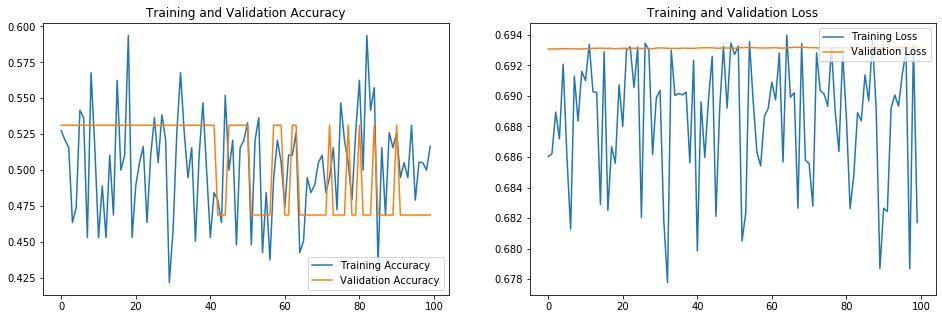

In [71]:
#print(fit_history.history.keys())
acc = fit_history.history['acc']
val_acc = fit_history.history['val_acc']

loss = fit_history.history['loss']
val_loss = fit_history.history['val_loss']

epochs_range = range(nb_epochs)

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
#plt.savefig('./VGG.binary.v7.png')
plt.show()